# Overview and Background
Customer is looking to develop a model that forecast the sales with a reliable model that can reliably predict the expected demand at each of the store location. This model will understand the correlation of events and attributes that drive the sales at each of the store.

# Project Objectives
1. Data Exploration – the objective is understand the data in the context of the sales forecast
a) Loading the data from CSV into pandas DataFrame
b) View and convert variables into correct data types
c) Impute missing data
d) Correcting time zone, if needed
2. Time Series Prep Tasks To Select Model Variables (Endogenous & Exogenous)
a) Ensure no data multicollinearity
b) Probe and fix autocorrelation
c) Ensure stationarity of each variable
d) Remove seasonality
e) Split data to train & test
3. Model Development
a) LAG order selection
b) Model build
4. Model structural analysis to ensure stability
a) Granger causality test
b) Impulse response chock test
c) Forecast Error Variance Decomposition
5. Run model and compare forecast to test data
6. Report results

#### Import required libraries

In [1]:
import pyodbc
import numpy as np
import pandas as pd
from fbprophet import Prophet
from matplotlib import pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

In [12]:
### Read and convert variables into correct data types

df = pd.read_excel('History.xlsx')

### View the data

df.head(n=10)

,DMDUNIT,DMDGROUP,LOC,STARTDATE,EVENT,HISTSTREAM,TYPE,QTY
0,20420241,AT_CO,CDC012,2020-01-19,,POS,1,2.0
1,20420241,AT_CO,CDC012,2020-02-02,,POS,1,2.0
2,20420241,AT_CO,CDC012,2020-02-09,,POS,1,2.0
3,20420241,AT_CO,CDC012,2020-02-16,,POS,1,3.0
4,20420241,AT_CO,CDC012,2020-02-23,,POS,1,2.0
5,20420241,AT_CO,CDC012,2020-03-01,,POS,1,2.0
6,20420241,AT_CO,CDC012,2020-03-08,,POS,1,2.0
7,20420241,AT_CO,CDC012,2020-03-15,,POS,1,9.0
8,20420241,AT_CO,CDC012,2020-03-22,,POS,1,19.0
9,20420241,AT_CO,CDC012,2020-03-29,,POS,1,44.0


In [24]:
df1 = df.copy()

In [25]:
# View data type

print(df1.dtypes)

DMDUNIT                int64
DMDGROUP              object
LOC                   object
STARTDATE     datetime64[ns]
EVENT                 object
HISTSTREAM            object
TYPE                   int64
QTY                  float64
dtype: object


In [26]:
# Test for NaN, missing, or Null data

print(df1.isnull().sum())

DMDUNIT       0
DMDGROUP      0
LOC           0
STARTDATE     0
EVENT         0
HISTSTREAM    0
TYPE          0
QTY           0
dtype: int64


In [27]:
# Display data stats

df1.describe(include='all').round(1)

,DMDUNIT,DMDGROUP,LOC,STARTDATE,EVENT,HISTSTREAM,TYPE,QTY
count,39850.0,39850,39850,39850,39850,39850,39850.0,39850.0
unique,NaN,41,366,113,152,1,NaN,NaN
top,NaN,CC,CDC031,2020-01-12 00:00:00,,POS,NaN,NaN
freq,NaN,31030,349,415,39068,39850,NaN,NaN
first,NaN,NaN,NaN,2018-09-02 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2020-10-25 00:00:00,NaN,NaN,NaN,NaN
mean,20420241.0,NaN,NaN,NaN,NaN,NaN,1.0,221.9
std,0.0,NaN,NaN,NaN,NaN,NaN,0.3,1958.7
min,20420241.0,NaN,NaN,NaN,NaN,NaN,1.0,-50000.0
25%,20420241.0,NaN,NaN,NaN,NaN,NaN,1.0,23.0


In [28]:
df1 = df1[df1['DMDGROUP']=='CC']
df1['LOC'].value_counts()

STO178    118
STO408    117
STO023    116
STO507    116
STO278    116
STO389    116
STO489    116
STO444    115
STO309    115
STO060    114
STO086    114
STO083    114
STO182    114
STO435    113
STO199    113
STO378    113
STO188    113
STO311    113
STO329    113
STO306    113
STO179    113
STO307    113
STO391    113
STO091    113
STO205    113
STO423    112
STO371    112
STO007    112
STO224    112
STO433    112
         ... 
STO177     98
STO029     98
STO531     98
STO194     97
STO252     96
STO969     96
STO218     96
STO219     95
STO553     95
STO253     94
STO127     94
STO331     89
STO503     87
STO567     82
STO150     78
STO500     71
STO577     64
STO407     62
STO562     58
STO534     52
STO132     49
STO561     46
STO580     39
STO554     36
STO591     28
STO613     16
STO588     13
STO623      8
STO551      7
STO626      2
Name: LOC, Length: 299, dtype: int64

In [30]:

#df1 = pd.read_excel('History.xlsx')
df1 = df1[df1['DMDGROUP']=='CC']
df1 = df1[df1['LOC']=='STO178']
df1 = df1[['STARTDATE','QTY']]
df1['STARTDATE'] =pd.to_datetime(df1.STARTDATE)
df1 = df1.sort_values(by='STARTDATE')

# For Future dates
length = df1.shape [-1 ]
start = df1 [ 'STARTDATE' ].iloc [-1 ]
future_dates = pd.date_range( start, periods = 21, freq = 'W' )

#df1 = df1.set_index('STARTDATE')
#df1 = df1.iloc[4000:]

In [31]:
future_dates = future_dates.delete(0)
future_dates

DatetimeIndex(['2020-11-01', '2020-11-08', '2020-11-15', '2020-11-22',
               '2020-11-29', '2020-12-06', '2020-12-13', '2020-12-20',
               '2020-12-27', '2021-01-03', '2021-01-10', '2021-01-17',
               '2021-01-24', '2021-01-31', '2021-02-07', '2021-02-14',
               '2021-02-21', '2021-02-28', '2021-03-07', '2021-03-14'],
              dtype='datetime64[ns]', freq='W-SUN')

In [32]:
df1.head(5)

,STARTDATE,QTY
9593,2018-09-02,14.0
9594,2018-09-09,58.0
9595,2018-09-16,65.0
9596,2018-09-23,66.0
9597,2018-09-30,83.0


In [33]:
# Convert indexes into pandas datetime, so that they are in right format
#df1.index = pd.to_datetime(df1.index)

# Remove duplicates
df1 = df1[~df1.index.duplicated()]
df1.shape

(118, 2)

In [34]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 9593 to 9710
Data columns (total 2 columns):
STARTDATE    118 non-null datetime64[ns]
QTY          118 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.8 KB


[134.0, 82.0, 95.0, 89.0, 90.0, 82.0, 65.0, 91.0, 60.0, 74.0, 46.0, 49.0, 39.0, 56.0, 69.0, 33.0, 54.0, 37.0, 47.0, 51.0, 49.0, 20.0, 16.0, 11.0, 19.0, 25.0, 67.0, 73.0, 37.0, 54.0, 55.0, 67.0, 83.0, 55.0, 51.0, 67.0, 54.0, 58.0, 86.0, 109.0, 145.0, 168.0, 234.0, 231.0, 292.0, 296.0, 278.0, 409.0, 439.0, 468.0, 201.0, 286.0, 221.0, 47.2484149749653, 109.435297690447, 282.0, 276.0, 113.577211922372, 220.0, 67.0677538496659, 230.0, 82.9193319620969, 159.0, 132.0, 145.0, 140.0, 94.0, 8.0, 3.0, 7.0, 7.0, 6.0, 17.0, 24.0, 11.0, 108.0, 126.0, 132.0, 58.0, 94.0, 72.0, 52.0, 55.0, 92.0, 82.0, 79.0, 93.0, 102.0, 73.0, 97.0, 106.0, 101.0, 83.0, 120.0, 86.0, 102.0, 110.0, 126.0, 89.0, 20.0]


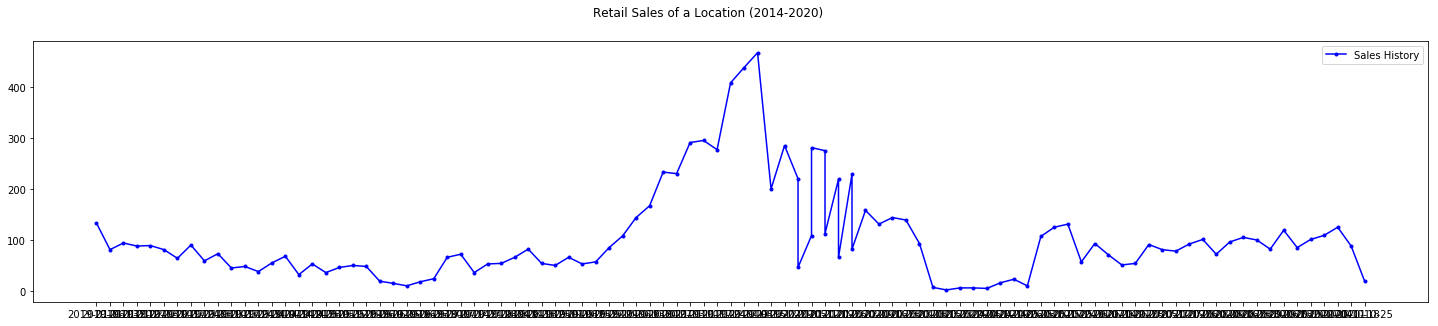

In [37]:
# View the data for a particular location - STO178

historical_val = df1['QTY'].tolist()[-100:]
startdate_historical = df1['STARTDATE'].astype(str).tolist()[-100:]
fig = plt.figure(figsize = [25, 4.8])
fig.suptitle('Retail Sales of a Location (2014-2020)')
past, = plt.plot(startdate_historical, historical_val, 'b.-', label='Sales History')
#future, = plt.plot(df_test.index, df_test, 'r.-', label='Actual Sales')
#predicted_future, = plt.plot(startdate[-84:], forecasted_val[-84:], 'g.-', label='Sales Forecast')
plt.legend(handles=[past])
print(historical_val)
#print(forecasted_val)
plt.show()


### Model Development

In [194]:
#split between the training and the test data sets. The last 12 periods form the test data
df_train = df1.iloc[:-30]
df_test = df1.iloc[-30:]

#build and train the model on the training data
model = HWES(df_train.iloc[:,0], seasonal_periods=12, trend='add', seasonal='add')
fitted = model.fit(optimized=True, use_brute=True)

#print out the training summary
print(fitted.summary())


                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  283
Model:             ExponentialSmoothing   SSE                          30277.788
Optimized:                         True   AIC                           1354.381
Trend:                         Additive   BIC                           1412.708
Seasonal:                      Additive   AICC                          1356.971
Seasonal Periods:                    12   Date:                 Tue, 03 Nov 2020
Box-Cox:                          False   Time:                         08:12:36
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0526316                alpha                 True
smoothing_slope          

/home/ubuntu/.local/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/ubuntu/.local/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [195]:
df_test.index

DatetimeIndex(['2020-03-29', '2020-04-05', '2020-04-12', '2020-04-19',
               '2020-04-26', '2020-05-03', '2020-05-10', '2020-05-17',
               '2020-05-24', '2020-05-31', '2020-06-07', '2020-06-14',
               '2020-06-21', '2020-06-28', '2020-07-05', '2020-07-12',
               '2020-07-19', '2020-07-26', '2020-08-02', '2020-08-09',
               '2020-08-16', '2020-08-23', '2020-08-30', '2020-09-06',
               '2020-09-13', '2020-09-20', '2020-09-27', '2020-10-04',
               '2020-10-11', '2020-10-18'],
              dtype='datetime64[ns]', name='STARTDATE', freq=None)

/home/ubuntu/.local/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


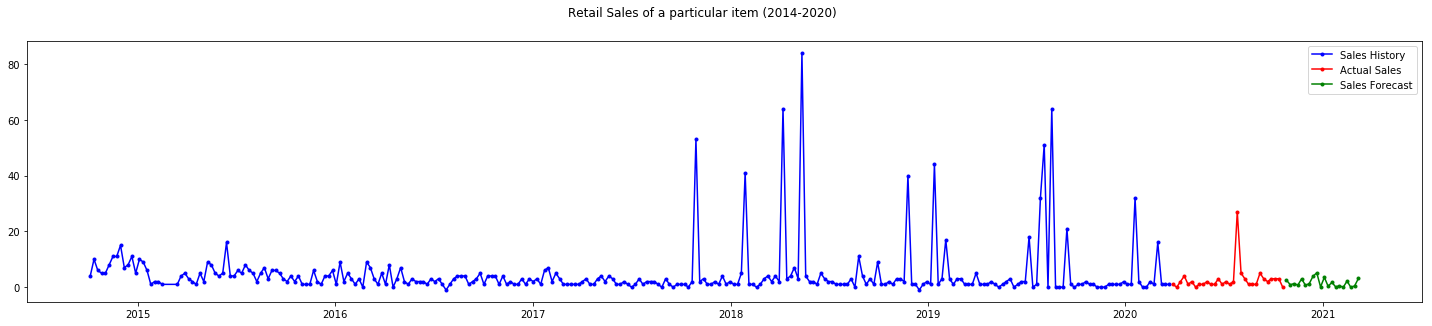

In [200]:
#create an out of sample forcast for the next 12 steps beyond the final data point in the training data set
sales_forecast = fitted.forecast(steps=50)

#plot the training data, the test data and the forecast on the same plot
fig = plt.figure(figsize = [25, 4.8])
fig.suptitle('Retail Sales of a particular item (2014-2020)')
past, = plt.plot(df_train.index, df_train, 'b.-', label='Sales History')
future, = plt.plot(df_test.index, df_test, 'r.-', label='Actual Sales')
predicted_future, = plt.plot(future_dates, sales_forecast[30:], 'g.-', label='Sales Forecast')
plt.legend(handles=[past, future, predicted_future])
plt.show()

### Forecasting for each location and save the results in Azure SQL DB

In [30]:
server = 'ikearfpserver1.database.windows.net'
database = 'ikearfpdb'
username = 'rfpadmin'
password = '*****'   
driver= '{ODBC Driver 17 for SQL Server}'

In [38]:
#df = pd.read_excel('Hist.xlsx')
df2 = pd.read_excel('History.xlsx')
df2.head(5)

,DMDUNIT,DMDGROUP,LOC,STARTDATE,EVENT,HISTSTREAM,TYPE,QTY
0,20420241,AT_CO,CDC012,2020-01-19,,POS,1,2.0
1,20420241,AT_CO,CDC012,2020-02-02,,POS,1,2.0
2,20420241,AT_CO,CDC012,2020-02-09,,POS,1,2.0
3,20420241,AT_CO,CDC012,2020-02-16,,POS,1,3.0
4,20420241,AT_CO,CDC012,2020-02-23,,POS,1,2.0


In [39]:
df = df2.copy()

In [40]:
df = df[['DMDGROUP','LOC','STARTDATE','QTY']]
df.rename(columns={'STARTDATE':'ds','QTY':'y'},inplace=True)
dmdgroup_list = df['DMDGROUP'].unique().tolist()

In [44]:
df = df[df['DMDGROUP']=='CC']
print(df.shape)
counts = df['LOC'].value_counts()
df =df[df['LOC'].isin(counts[counts > 1].index)]
print(df.shape)
location_list = df['LOC'].unique().tolist()
#remove_loc = ['STO019','STO023','STO047','STO051','STO060','STO063','STO069','STO083','STO086','STO119','STO121','STO127']



#location_list = [loc for loc in location_list if loc not in remove_loc]

for i in location_list[:1]:
    
    temp_df = df[df['LOC']==i]
    temp_df = temp_df[['ds','y']]
    temp_df['ds'] =pd.to_datetime(temp_df.ds)
    temp_df = temp_df.sort_values(by='ds')
    temp_date = temp_df.tail(1)['ds'].tolist()[0]
    #print(temp_date)
    if(temp_date < pd.Timestamp('2020-10-24')):
        print('Last date falls before 24th Oct')
        continue
    print("Started forecast for ",i)
    print(temp_df.shape)
    #temp_df.y = np.where(temp_df.y <= 0, 1,temp_df.y)
  
    #print(temp_df['y'])
    m = Prophet()
    m.fit(temp_df)
    model = HWES(temp_df.iloc[:,1], seasonal_periods=8,trend='add',  seasonal='add')
    future = m.make_future_dataframe(periods=84,freq='W')
    #print(future.head())
    print('Made future dataframe')
    #forecast = m.predict(future)
    fitted = model.fit(optimized=True, use_brute=True)
    print('Fitted the model')
    print('Shape of future df -',future.shape)
    forecast = fitted.forecast(steps=84)
    temp_hist_list = temp_df['y'].tolist()
    temp_hist_list.extend(forecast.tolist())
    #print('Type of the new list - ',type(temp_hist_list))
    #print('Length of the new list - ',len(temp_hist_list))
    future['forecasted_QTY'] = temp_hist_list
    future['Mean_Value'] = future['forecasted_QTY'].rolling(3).mean() 
    forecasted_df = future[['ds','forecasted_QTY','Mean_Value']].tail(84)
    #forecasted_df['Mean_Value'] = forecasted_df['forecasted_QTY'].rolling(3).mean() 
    #print(forecasted_df.head())
    historical_val = temp_df['y'].tolist()[-100:]
    startdate_historical = temp_df['ds'].astype(str).tolist()[-100:]
    startdate = forecasted_df['ds'].astype(str).tolist()
    forecasted_val = forecasted_df['forecasted_QTY'].tolist()
    #print(forecasted_val)
    mean_val = forecasted_df['Mean_Value'].tolist()
    #mean_val[0] = 0
    #mean_val[1] = 0
    #print(forecast)
#     with pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password) as conn:
#         with conn.cursor() as cursor:
#             for j in range(len(forecasted_val)):
#                 #print(startdate[i])
#                 #print(forecasted_val[i])
#                 cursor.execute("insert into dbo.FCST1 (DMDUNIT,DMDGROUP,LOC,STARTDATE,Mean,QTY,MODEL,Seasonality_Ind) values (196530,'CC','"+str(i)+"','"+startdate[j]+"', "+str(mean_val[j])+","+str(forecasted_val[j])+",'Holt Winters',0)")
    print("Finished for ",i)
    

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(31030, 4)
(31030, 4)
Started forecast for  STO001
(110, 2)
Made future dataframe
Fitted the model
Shape of future df - (194, 1)
Finished for  STO001


/home/ubuntu/.local/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/ubuntu/.local/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/ubuntu/.local/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



[220.0, 156.0, 175.0, 139.0, 123.0, 105.0, 94.0, 53.0, 74.0, 65.0, 38.0, 50.0, 45.0, 70.0, 39.0, 43.0, 39.0, 52.0, 38.0, 71.0, 49.0, 35.0, 49.0, 24.0, 30.0, 26.0, 27.0, 39.0, 34.0, 34.0, 43.0, 23.0, 32.0, 49.0, 48.0, 49.0, 47.0, 52.0, 64.0, 62.0, 53.0, 45.0, 123.0, 100.0, 33.0, 32.0, 31.0, 68.0, 35.0, 76.0, 51.0, 64.0, 205.0, 224.0, 264.0, 173.0, 110.0, 58.0, 48.0, 36.0, 47.0, 49.0, 36.0, 47.0, 52.0, 48.0, 9.0, 1.0, 5.0, 3.0, 5.0, 5.0, 6.0, 17.0, 6.0, 4.0, 4.0, 2.0, 3.0, 1.0, 55.0, 36.0, 58.0, 44.0, 30.0, 28.0, 36.0, 37.0, 55.0, 146.0, 239.0, 232.0, 215.0, 218.0, 230.0, 270.0, 231.0, 175.0, 179.0, 152.0]
[159.35480878623835, 175.94919633190847, 188.66734757097072, 193.41997923896443, 175.86675685060456, 173.11365275636996, 194.17877472461123, 177.3232261690384, 181.91519058781222, 198.50957813348236, 211.22772937254462, 215.9803610405383, 198.42713865217843, 195.67403455794383, 216.73915652618507, 199.88360797061227, 204.47557238938612, 221.06995993505623, 233.78811117411848, 238.54074

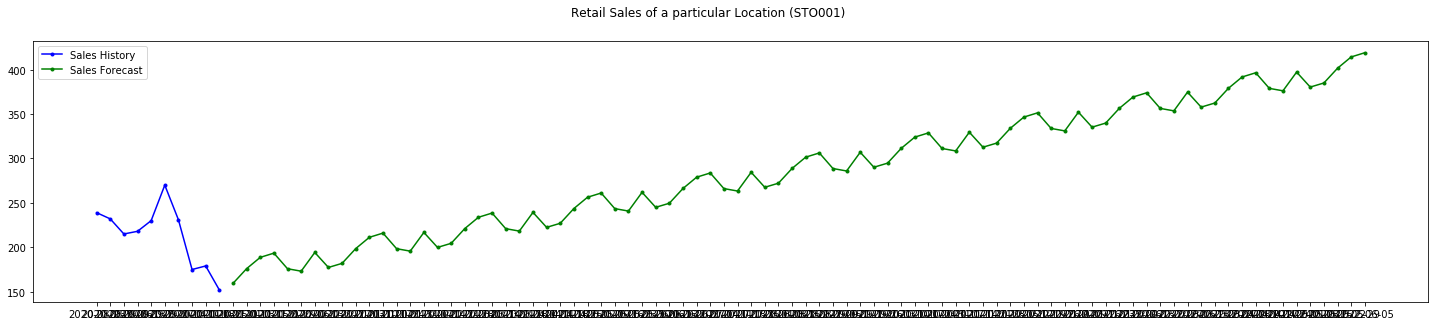

In [43]:
#create an out of sample forcast for the next 12 steps beyond the final data point in the training data set
#sales_forecast = fitted.forecast(steps=84)

#plot the training data, the test data and the forecast on the same plot
fig = plt.figure(figsize = [25, 4.8])
fig.suptitle('Retail Sales of a particular Location (STO001)')
past, = plt.plot(startdate_historical[-10:], historical_val[-10:], 'b.-', label='Sales History')
#future, = plt.plot(df_test.index, df_test, 'r.-', label='Actual Sales')
predicted_future, = plt.plot(startdate[-84:], forecasted_val[-84:], 'g.-', label='Sales Forecast')
plt.legend(handles=[past,  predicted_future])
print(historical_val)
print(forecasted_val)
plt.show()


[220.0, 156.0, 175.0, 139.0, 123.0, 105.0, 94.0, 53.0, 74.0, 65.0, 38.0, 50.0, 45.0, 70.0, 39.0, 43.0, 39.0, 52.0, 38.0, 71.0, 49.0, 35.0, 49.0, 24.0, 30.0, 26.0, 27.0, 39.0, 34.0, 34.0, 43.0, 23.0, 32.0, 49.0, 48.0, 49.0, 47.0, 52.0, 64.0, 62.0, 53.0, 45.0, 123.0, 100.0, 33.0, 32.0, 31.0, 68.0, 35.0, 76.0, 51.0, 64.0, 205.0, 224.0, 264.0, 173.0, 110.0, 58.0, 48.0, 36.0, 47.0, 49.0, 36.0, 47.0, 52.0, 48.0, 9.0, 1.0, 5.0, 3.0, 5.0, 5.0, 6.0, 17.0, 6.0, 4.0, 4.0, 2.0, 3.0, 1.0, 55.0, 36.0, 58.0, 44.0, 30.0, 28.0, 36.0, 37.0, 55.0, 146.0, 239.0, 232.0, 215.0, 218.0, 230.0, 270.0, 231.0, 175.0, 179.0, 152.0]
[380.5036438123813, 342.78223909822566, 319.4258942187612, 335.64991237921885, 263.8475114767294, 217.98298263936658, 248.85488692323543, 547.7793236397043, 468.8407186801593, 420.11771813217786, 389.51530389584434, 407.33312703516276, 318.7310626116237, 262.1770299030863, 298.0609202757709, 653.479133076815, 557.1777935479373, 497.45319716613, 459.60471357292755, 479.0163416911067, 37

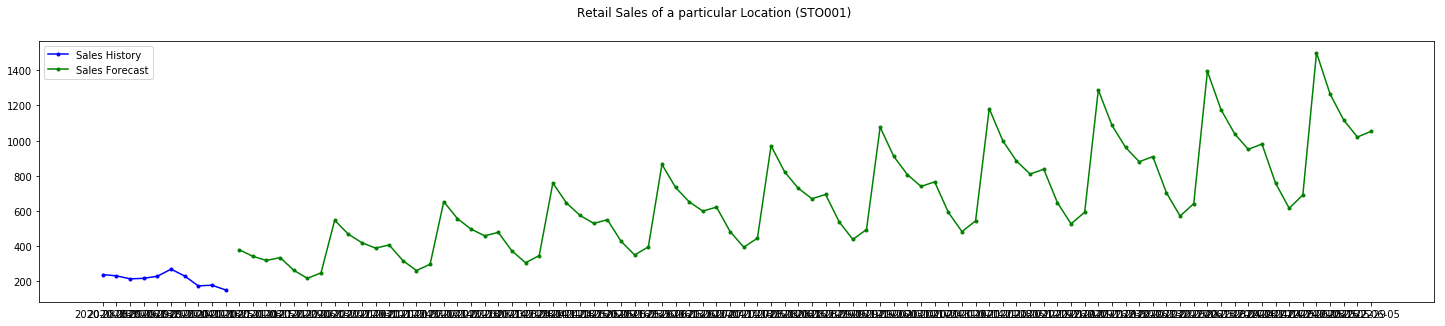

In [45]:
#plot the training data and the forecast on the same plot with different Seasonality parameters
fig = plt.figure(figsize = [25, 4.8])
fig.suptitle('Retail Sales of a particular Location (STO001)')
past, = plt.plot(startdate_historical[-10:], historical_val[-10:], 'b.-', label='Sales History')
#future, = plt.plot(df_test.index, df_test, 'r.-', label='Actual Sales')
predicted_future, = plt.plot(startdate[-84:], forecasted_val[-84:], 'g.-', label='Sales Forecast')
plt.legend(handles=[past,  predicted_future])
print(historical_val)
print(forecasted_val)
plt.show()